In [17]:
# We have to install 'sentence-transformers'
!pip install sentence-transformers pandas scikit-learn matplotlib
print("Libraries installed.")

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

# Loading a free, local embedding model
print("Loading local embedding model (all-MiniLM-L6-v2)...")
model = SentenceTransformer('all-MiniLM-L6-v2')
print("Model loaded successfully.")

Libraries installed.
Loading local embedding model (all-MiniLM-L6-v2)...
Model loaded successfully.


**As we can see, All the required libraries has been imported succesfully. The model is locally embedded because openai free api key was getting exausted.**

In [18]:
# We have created a mock product data
data = [
    {"product_id": "p001", "name": "Boho Festival Dress", "desc": "A flowy, maxi dress with earthy tones and paisley prints. Perfect for festival vibes and sunny days.", "vibes": ["boho", "festival", "casual", "earthy"]},
    {"product_id": "p002", "name": "Minimalist White Tee", "desc": "A high-quality, pure cotton crewneck. Clean lines, versatile, and a staple for any modern, simple wardrobe.", "vibes": ["minimalist", "modern", "staple", "casual"]},
    {"product_id": "p003", "name": "Urban Tech Runner", "desc": "Sleek, black-on-black design with reflective highlights. Lightweight and built for the city streets. Energetic and fast.", "vibes": ["urban", "energetic", "modern", "athletic", "chic"]},
    {"product_id": "p004", "name": "Vintage Denim Jacket", "desc": "Classic, faded light-blue wash. Perfectly worn-in feel with copper buttons. Casual, timeless, and a bit rebellious.", "vibes": ["vintage", "casual", "timeless", "rebellious"]},
    {"product_id": "p005", "name": "Silk Slip Dress", "desc": "Elegant, luxurious 100% silk. A bias-cut dress perfect for a sophisticated evening, a gala, or a high-end dinner.", "vibes": ["elegant", "sophisticated", "luxury", "formal"]},
    {"product_id": "p006", "name": "Cozy Knit Sweater", "desc": "An oversized, chunky knit pullover in a warm wool blend. Like a warm hug on a cold day. Perfect for relaxing by the fire.", "vibes": ["cozy", "relaxing", "casual", "warm"]},
    {"product_id": "p007", "name": "Punk Leather Biker", "desc": "Asymmetric zip, silver hardware, and a belted waist. This jacket has an edgy, rebellious spirit. Built to make a statement.", "vibes": ["punk", "edgy", "rebellious", "statement", "urban"]},
    {"product_id": "p008", "name": "Athleisure Joggers", "desc": "Comfortable, tapered-fit joggers. Technical fabric that wicks sweat. Perfect for the gym, the cafe, or an active lifestyle.", "vibes": ["athletic", "casual", "comfort", "modern"]},
    {"product_id": "p009", "name": "Chic Tailored Blazer", "desc": "Sharp, tailored fit with a single-button closure. Instantly elevates any outfit for a professional or smart-casual look. Boss energy.", "vibes": ["chic", "professional", "smart-casual", "elegant"]},
    {"product_id": "p010", "name": "Graphic Street Hoodie", "desc": "A bold, oversized hoodie with a graffiti-style print on the back. Makes a statement. Pure street style for a youthful, urban look.", "vibes": ["street", "urban", "youthful", "statement", "casual"]},
]

# Data is now converted into a DataFrame
df = pd.DataFrame(data)
print(f"Created a product database with {len(df)} items.")
df.head(3)

Created a product database with 10 items.


,product_id,name,desc,vibes
0,p001,Boho Festival Dress,"A flowy, maxi dress with earthy tones and pais...","[boho, festival, casual, earthy]"
1,p002,Minimalist White Tee,"A high-quality, pure cotton crewneck. Clean li...","[minimalist, modern, staple, casual]"
2,p003,Urban Tech Runner,"Sleek, black-on-black design with reflective h...","[urban, energetic, modern, athletic, chic]"


This is a Sample data generated with the help of AI.

In [21]:
# Helper function to get embeddings using the local model
def get_embedding(text):
    # Simple error handling for empty text
    if not text or not isinstance(text, str):
        return None

    text = text.replace("\n", " ")
    try:
        embedding = model.encode(text)
        return embedding
    except Exception as e:
        print(f"Error generating embedding: {e}")
        return None

# Generating embeddings for each product description
print("Generating embeddings for product descriptions...")
df['embedding'] = df['desc'].apply(get_embedding)

if not df['embedding'].isnull().all():
    product_embeddings_matrix = np.stack(df['embedding'].dropna().values)
    print("Embeddings generated and stored.")
    display(df[['name', 'embedding']])
else:
    print("No embeddings were generated.")
    product_embeddings_matrix = None

Generating embeddings for product descriptions...
Embeddings generated and stored.


,name,embedding
0,Boho Festival Dress,"[-0.09347521, 0.047758292, 0.073798284, 0.0054..."
1,Minimalist White Tee,"[-0.08070783, 0.025717584, -0.020790696, 0.014..."
2,Urban Tech Runner,"[-0.026347738, 0.071457006, 0.026552912, 0.084..."
3,Vintage Denim Jacket,"[-0.12846747, 0.09397004, 0.07505107, 0.031486..."
4,Silk Slip Dress,"[-0.040073927, 0.057700627, 0.034251627, 0.034..."
5,Cozy Knit Sweater,"[-0.08497586, 0.039935835, 0.043890785, 0.0843..."
6,Punk Leather Biker,"[-0.040324688, 0.17301641, 0.020165663, 0.0629..."
7,Athleisure Joggers,"[-0.050820697, 0.03448358, 0.013801453, 0.1002..."
8,Chic Tailored Blazer,"[-0.07053238, 0.049680658, 0.007946694, 0.0624..."
9,Graphic Street Hoodie,"[-0.030670358, 0.10898844, 0.038068797, 0.0455..."


**We can see the generated embedding for the description. This will help us finding a good match.**

In [22]:
def find_vibe_matches(query, df, product_embeddings, n=3, no_match_threshold=0.75):
    start_time = time.time() #
    # Get embedding for the user's query
    query_embedding = get_embedding(query)
    if query_embedding is None:
        return "Error: Could not process query.", 0.0

    query_vec = np.array(query_embedding).reshape(1, -1)

    # Computing cosine similarity. This computes the similarity between the single query_vec and *all* product_embeddings
    sim_scores = cosine_similarity(query_vec, product_embeddings_matrix)

    sim_scores = sim_scores[0]
    top_n_indices = np.argsort(sim_scores)[-n:][::-1]
    results = []
    for idx in top_n_indices:
        results.append({
            "name": df.iloc[idx]['name'],
            "score": sim_scores[idx],
            "desc": df.iloc[idx]['desc']
        })

    end_time = time.time()
    latency = end_time - start_time

    # Handling edge cases.
    if results[0]['score'] < no_match_threshold:
        fallback_message = f"Sorry, I couldn't find a strong match for '{query}'.\nMaybe try searching for 'cozy' or 'urban'?"
        return fallback_message, latency

    return results, latency

--- Running Vibe Matcher Tests ---

QUERY: 'flowy maxi dress with paisley prints'
Match 1 (Score: 0.8027) [Good]
  Name: Boho Festival Dress
  Desc: A flowy, maxi dress with earthy tones and paisley prints. Perfect for festival vibes and sunny days.

Match 2 (Score: 0.4831) [Weak]
  Name: Silk Slip Dress
  Desc: Elegant, luxurious 100% silk. A bias-cut dress perfect for a sophisticated evening, a gala, or a high-end dinner.

Match 3 (Score: 0.4217) [Weak]
  Name: Graphic Street Hoodie
  Desc: A bold, oversized hoodie with a graffiti-style print on the back. Makes a statement. Pure street style for a youthful, urban look.

[Latency: 0.0242 seconds]

QUERY: 'high-quality pure cotton crewneck tee'
Match 1 (Score: 0.7606) [Good]
  Name: Minimalist White Tee
  Desc: A high-quality, pure cotton crewneck. Clean lines, versatile, and a staple for any modern, simple wardrobe.

Match 2 (Score: 0.4144) [Weak]
  Name: Athleisure Joggers
  Desc: Comfortable, tapered-fit joggers. Technical fabric th

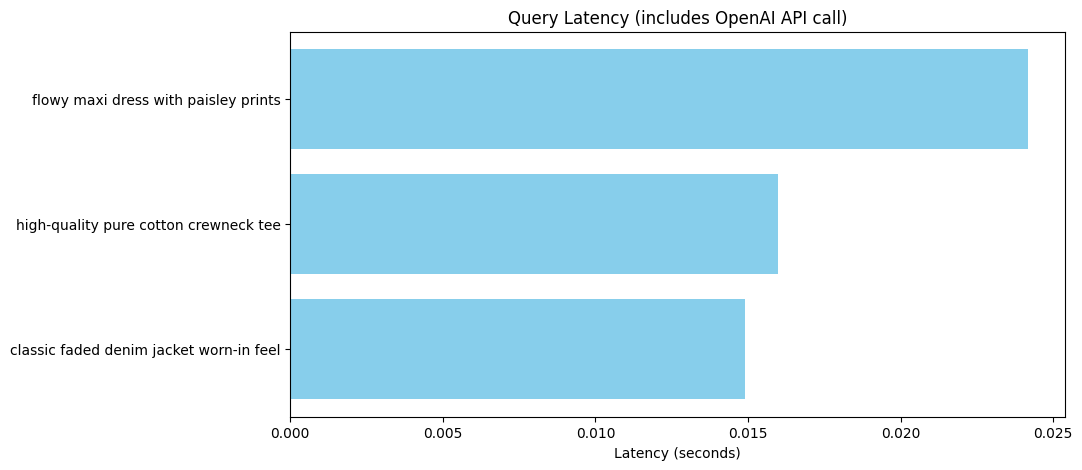

In [23]:
# --- Test Queries ---
queries = [
    "flowy maxi dress with paisley prints",
    "high-quality pure cotton crewneck tee",
    "classic faded denim jacket worn-in feel",
]

latencies = []
all_results = {}

print("--- Running Vibe Matcher Tests ---")

for q in queries:
    print(f"\n========================================")
    print(f"QUERY: '{q}'")
    print(f"========================================")

    results, latency = find_vibe_matches(q, df, product_embeddings_matrix, n=3)

    latencies.append(latency)
    all_results[q] = results

    if isinstance(results, str): # This is our fallback message
        print(results)
    else:
        for i, res in enumerate(results):
            # Log metrics: score > 0.7 is "good"
            match_quality = "Good" if res['score'] > 0.7 else "Weak"

            print(f"Match {i+1} (Score: {res['score']:.4f}) [{match_quality}]")
            print(f"  Name: {res['name']}")
            print(f"  Desc: {res['desc']}\n")

    print(f"[Latency: {latency:.4f} seconds]")

# --- Latency Evaluation ---
print("\n\n--- Latency Report ---")
for i, q in enumerate(queries):
    print(f"Query '{q[:20]}...': {latencies[i]:.4f}s")

# Plotting Latency
plt.figure(figsize=(10, 5))
plt.barh(queries, latencies, color='skyblue')
plt.xlabel("Latency (seconds)")
plt.title("Query Latency (includes OpenAI API call)")
plt.gca().invert_yaxis()
plt.show()